Mounted at /content/drive
Original dataset shape: (30000, 24)

Validation Set Performance:
Mean Absolute Error (MAE): 21502.02
Mean Squared Error (MSE): 948975515.96
R² Score: 0.56

Test Set Performance:
Mean Absolute Error (MAE): 21683.95
Mean Squared Error (MSE): 969390282.45
R² Score: 0.58


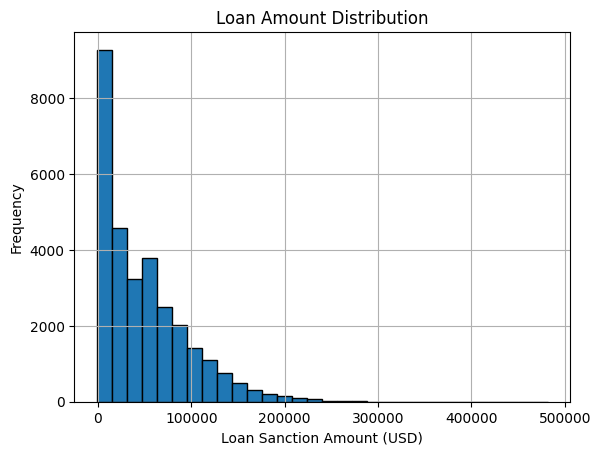

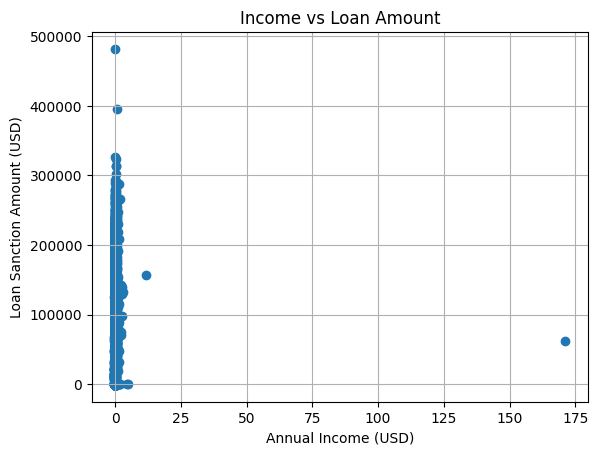

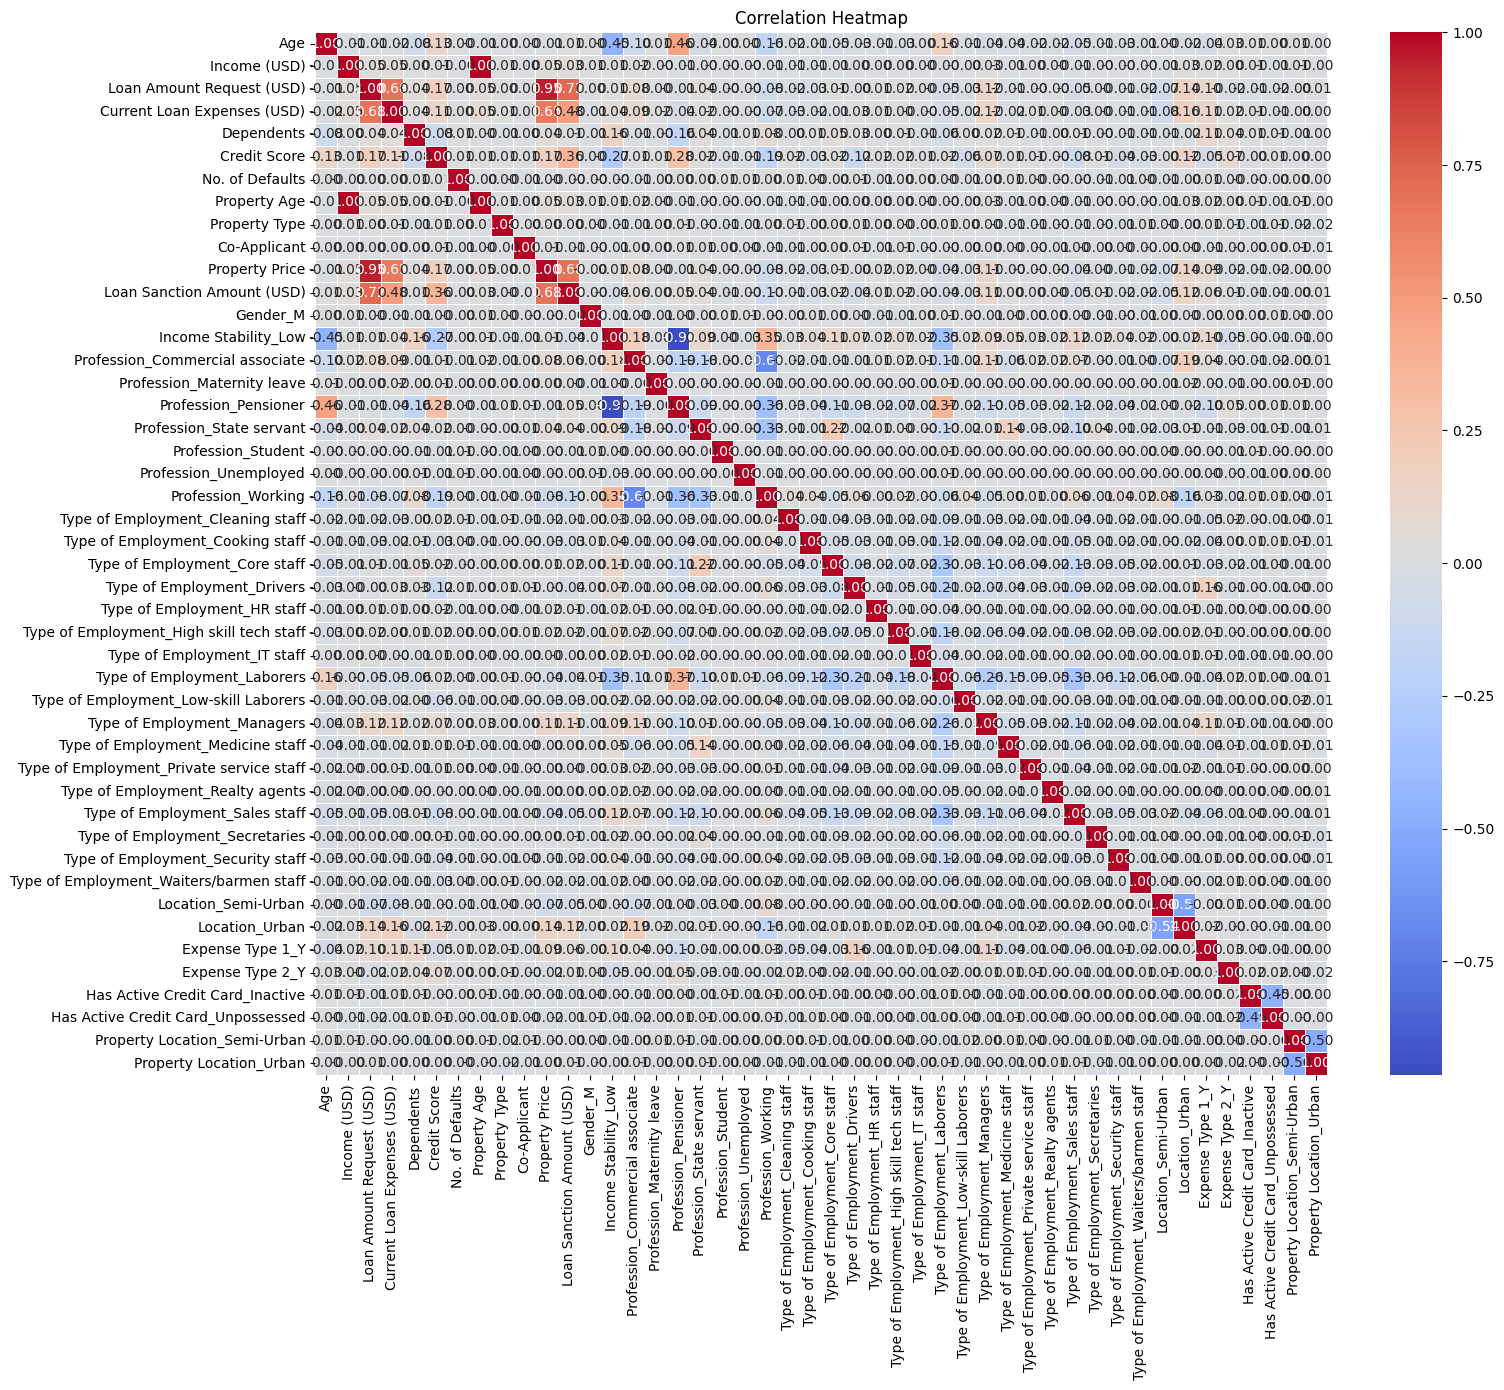

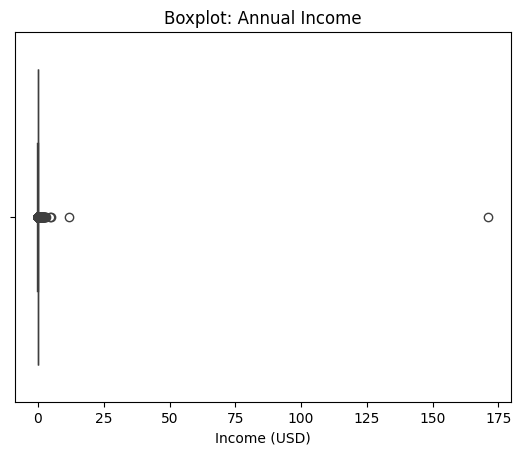

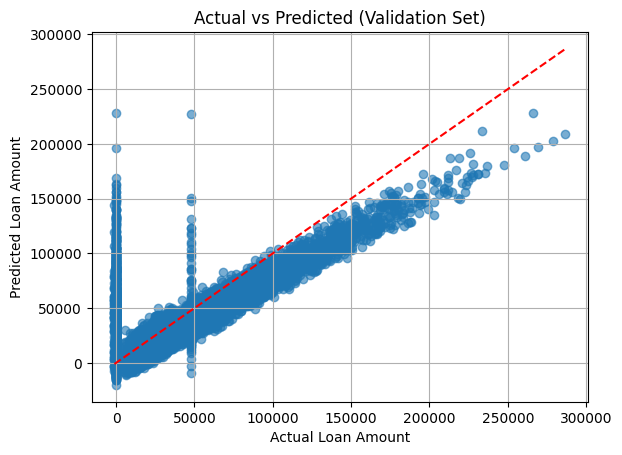

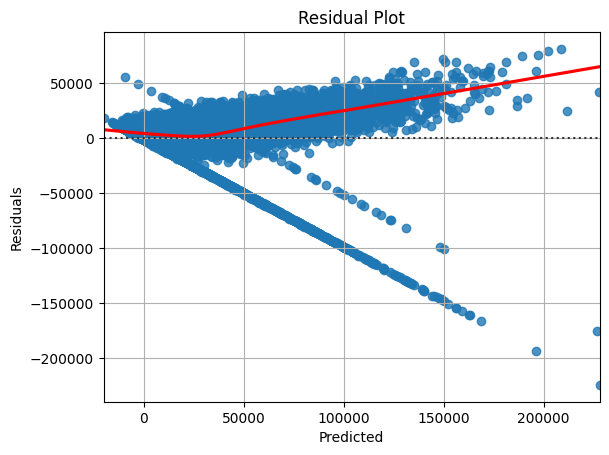

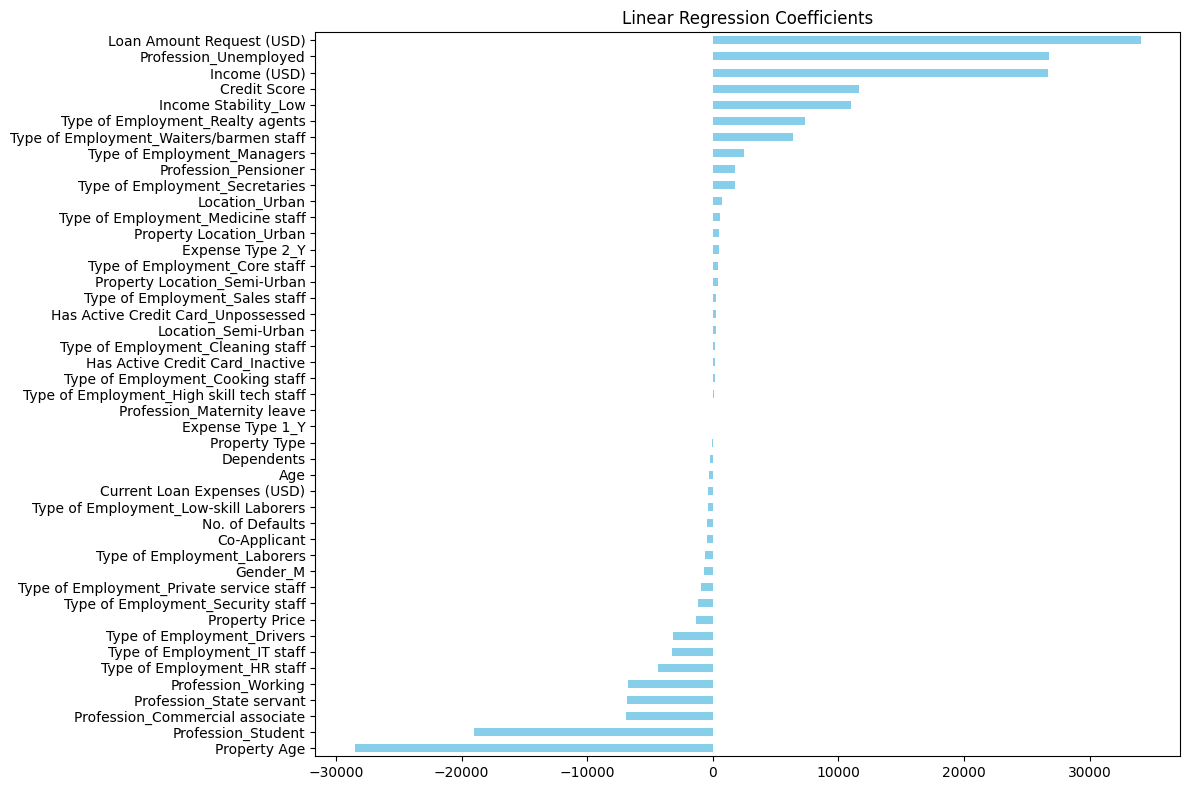

In [1]:
# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Load the dataset
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/train.csv'

# Load the dataset
df = pd.read_csv(file_path)
print("Original dataset shape:", df.shape)

# 3. Preprocessing function (without scaling target)
def preprocess(df, target=None):
    df = df.copy()

    # Drop unnecessary identifier columns
    drop_cols = ['Customer ID', 'Name', 'Property ID']
    for col in drop_cols:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

    # Fill missing numeric values with mean
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(df[col].mean())

    # Fill missing categorical values with mode
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    # One-hot encoding for categoricals
    df = pd.get_dummies(df, drop_first=True)

    # Scale numeric features EXCEPT target
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include='number').columns
    if target and target in num_cols:
        num_cols = num_cols.drop(target)
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

# 4. Apply preprocessing
target_col = 'Loan Sanction Amount (USD)'
df = preprocess(df, target=target_col)

# 5. Split into features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# 6. Split the data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 7. Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# 9. Evaluation Metrics
print("\nValidation Set Performance:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.2f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.2f}")

print("\nTest Set Performance:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_test_pred):.2f}")

# 10. EDA Visualizations
# Histogram of Target
plt.hist(y, bins=30, edgecolor='black')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Sanction Amount (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Scatter Plot
plt.scatter(X['Income (USD)'], y)
plt.xlabel("Annual Income (USD)")
plt.ylabel("Loan Sanction Amount (USD)")
plt.title("Income vs Loan Amount")
plt.grid(True)
plt.show()

# Correlation Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Boxplot for Income
sns.boxplot(x=X['Income (USD)'])
plt.title("Boxplot: Annual Income")
plt.show()

# 11. Evaluation Visuals
# Actual vs Predicted Plot (Validation)
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_val - y_val_pred
sns.residplot(x=y_val_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Coefficient Plot
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values().plot(kind='barh', figsize=(12, 8), color='skyblue')
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()


In [2]:
# ---------------- 5-Fold Cross-Validation ----------------
from sklearn.model_selection import KFold

# Prepare features and target as NumPy arrays
X_values = X.values
y_values = y.values

# Setup KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model
cv_model = LinearRegression()

# For storing fold results
fold_metrics = []

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X_values), start=1):
    X_train_cv, X_test_cv = X_values[train_idx], X_values[test_idx]
    y_train_cv, y_test_cv = y_values[train_idx], y_values[test_idx]

    cv_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = cv_model.predict(X_test_cv)

    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_cv, y_pred_cv)

    fold_metrics.append({
        'Fold': f'Fold {fold}',
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 3)
    })

# Average metrics across folds
avg_metrics = {
    'Fold': 'Average',
    'MAE': round(np.mean([f['MAE'] for f in fold_metrics]), 2),
    'MSE': round(np.mean([f['MSE'] for f in fold_metrics]), 2),
    'RMSE': round(np.mean([f['RMSE'] for f in fold_metrics]), 2),
    'R² Score': round(np.mean([f['R² Score'] for f in fold_metrics]), 3)
}
fold_metrics.append(avg_metrics)

# Display results
cv_results_df = pd.DataFrame(fold_metrics)
print(cv_results_df.to_markdown(index=False))




| Fold    |     MAE |         MSE |    RMSE |   R² Score |
|:--------|--------:|------------:|--------:|-----------:|
| Fold 1  | 21751.5 | 1.00019e+09 | 31625.7 |      0.565 |
| Fold 2  | 21853.8 | 9.79222e+08 | 31292.5 |      0.569 |
| Fold 3  | 22386.8 | 1.06407e+09 | 32620.1 |      0.54  |
| Fold 4  | 21760.1 | 9.95921e+08 | 31558.2 |      0.576 |
| Fold 5  | 21023.5 | 8.80309e+08 | 29670   |      0.61  |
| Average | 21755.1 | 9.83943e+08 | 31353.3 |      0.572 |



SVR Performance:
MAE: 34460.2727
MSE: 2134562863.7487
RMSE: 46199.8781
R²: 0.0715
Adjusted R²: 0.0645


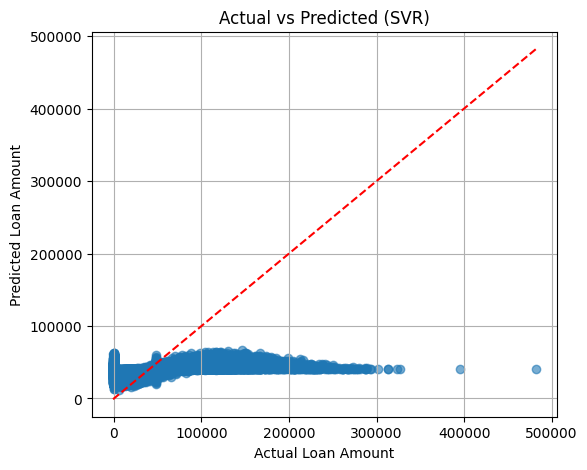

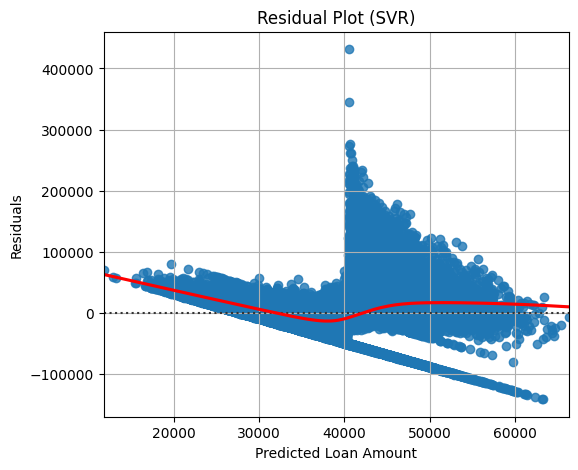

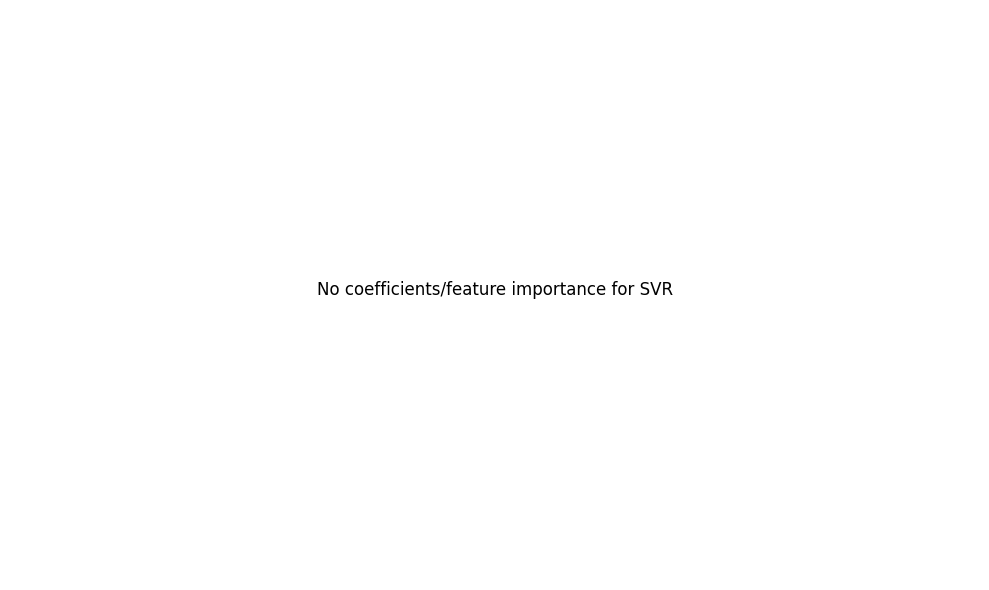


Decision Tree Performance:
MAE: 14332.7248
MSE: 1092663531.5612
RMSE: 33036.3616
R²: 0.5247
Adjusted R²: 0.5211


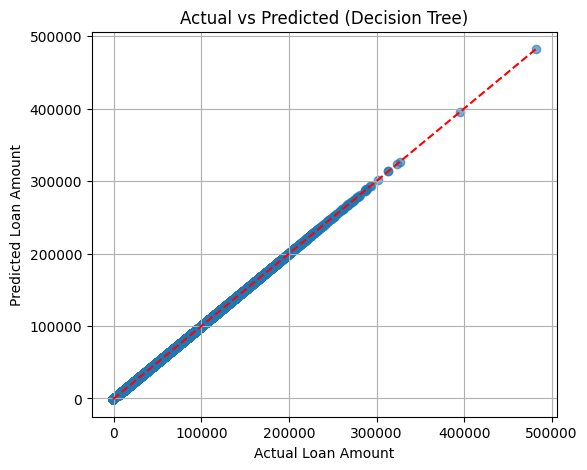

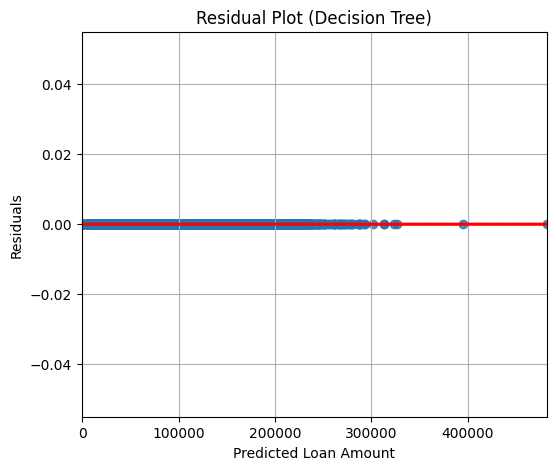

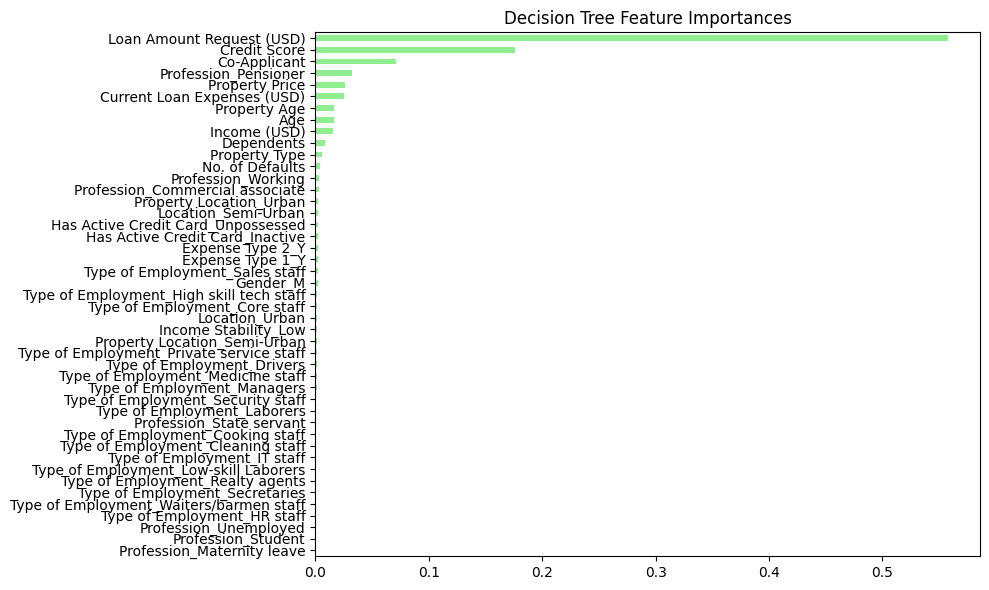


AdaBoost Performance:
MAE: 26943.0507
MSE: 1160478954.2134
RMSE: 34059.5875
R²: 0.4953
Adjusted R²: 0.4915


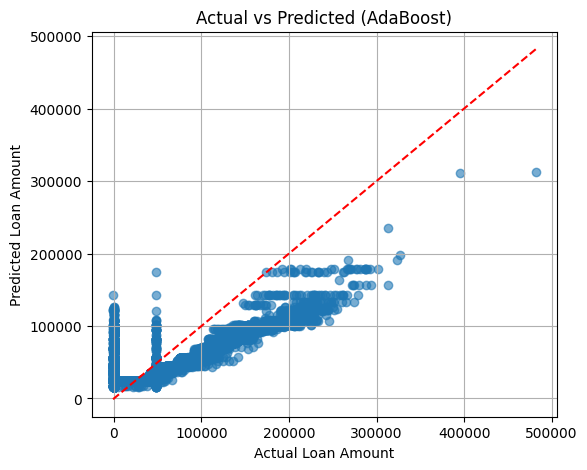

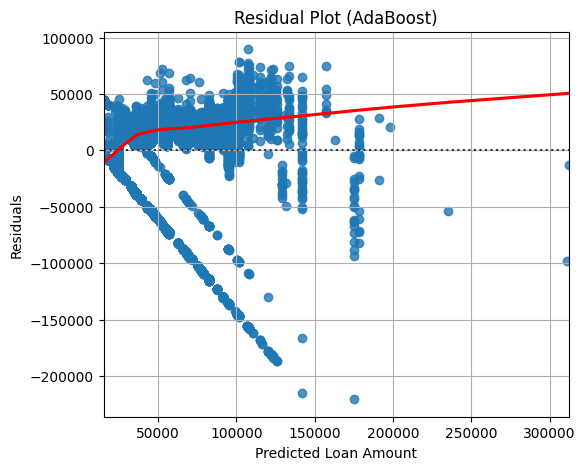

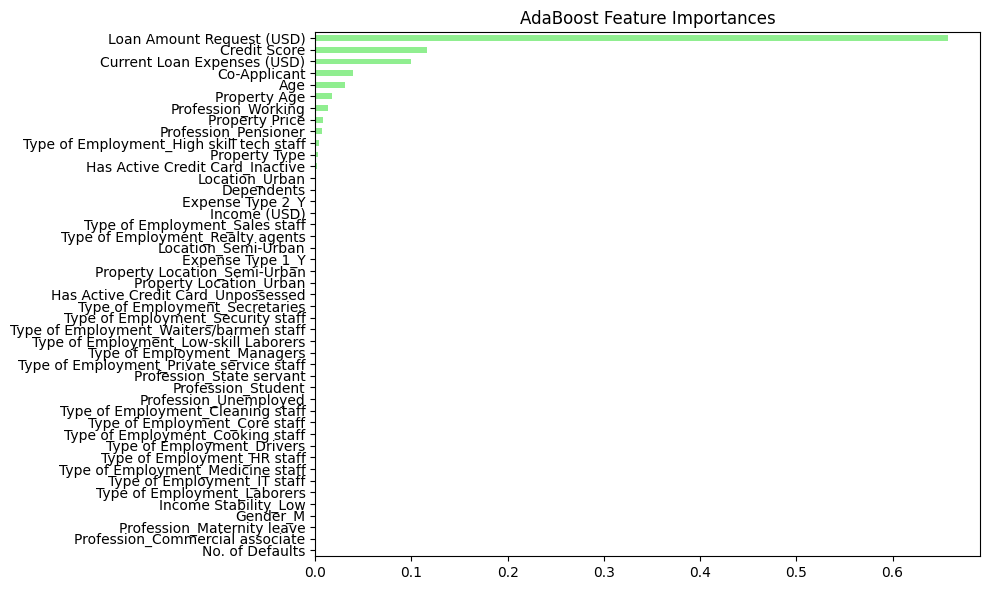


Gradient Boosting Performance:
MAE: 13638.4295
MSE: 575940703.7256
RMSE: 23985.0576
R²: 0.7496
Adjusted R²: 0.7477


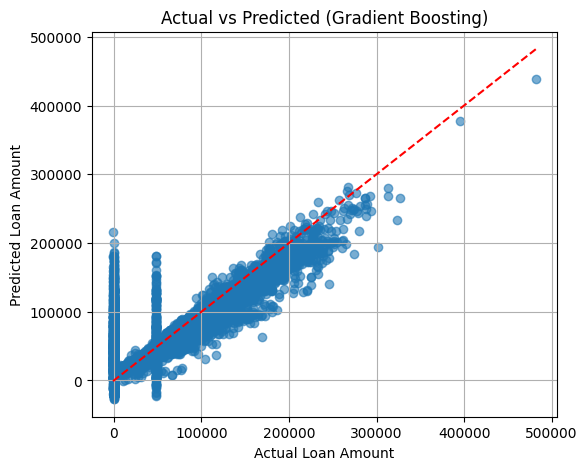

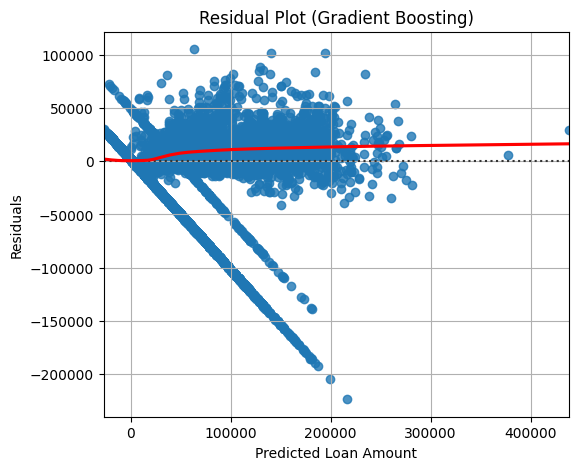

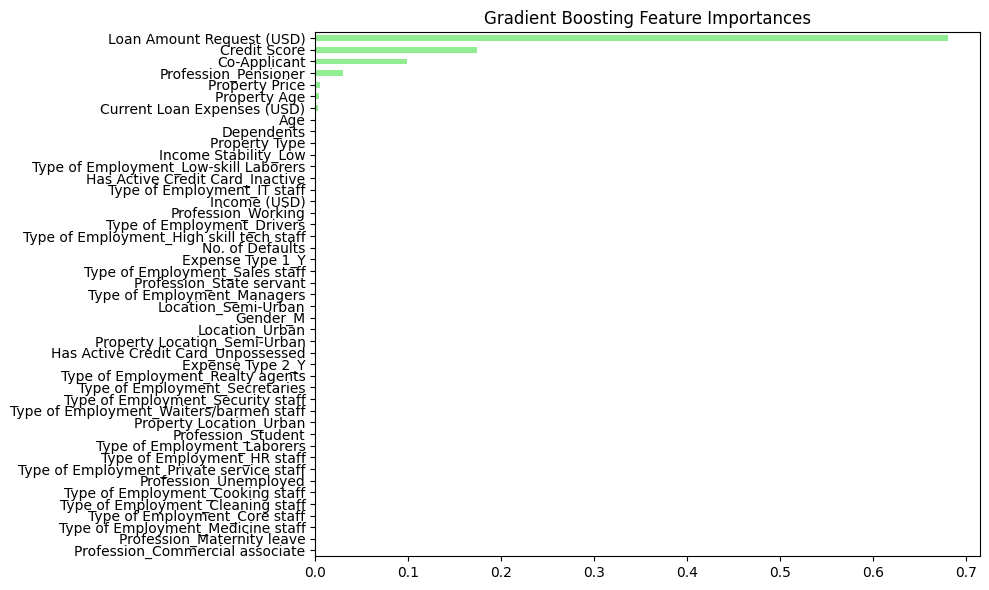


XGBoost Performance:
MAE: 12451.8217
MSE: 583299363.1479
RMSE: 24145.6165
R²: 0.7463
Adjusted R²: 0.7444


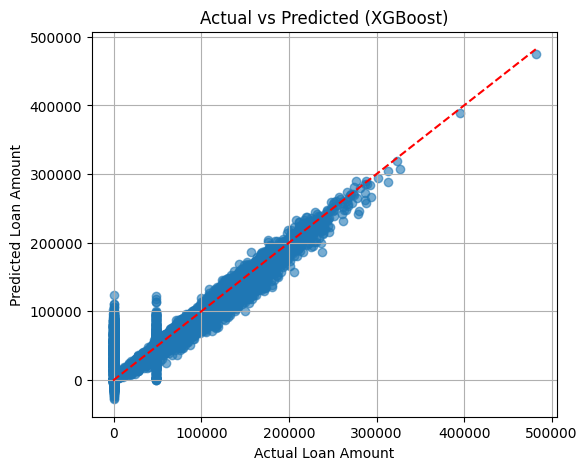

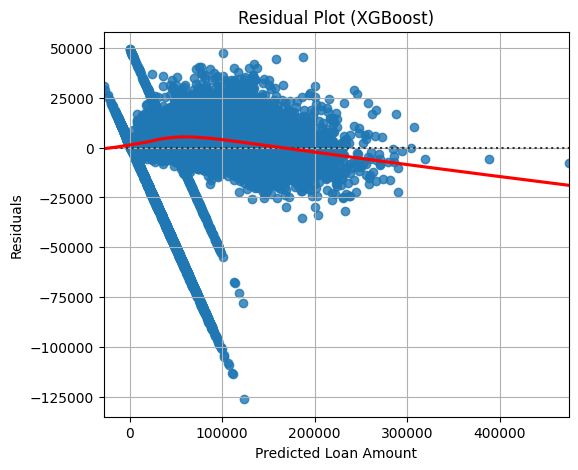

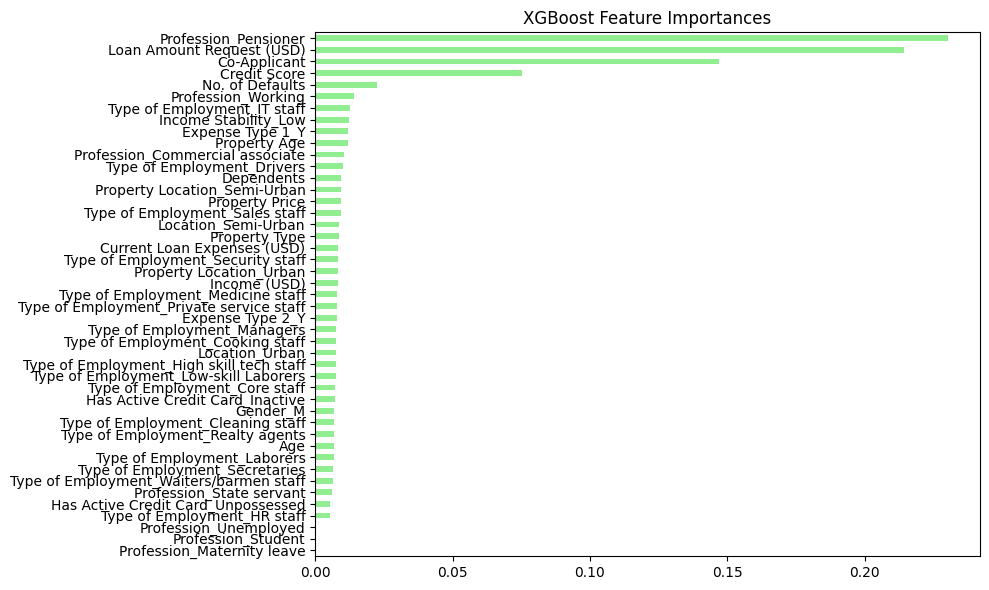

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.798e+12, tolerance: 5.517e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+13, tolerance: 5.533e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+13, tolerance: 5.508e


Lasso Performance:
MAE: 21754.3808
MSE: 983912986.0772
RMSE: 31352.8407
R²: 0.5721
Adjusted R²: 0.5689


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+13, tolerance: 6.897e+09
  model = cd_fast.enet_coordinate_descent(


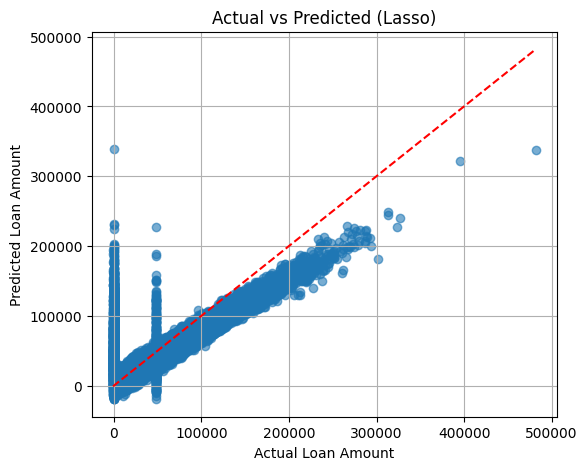

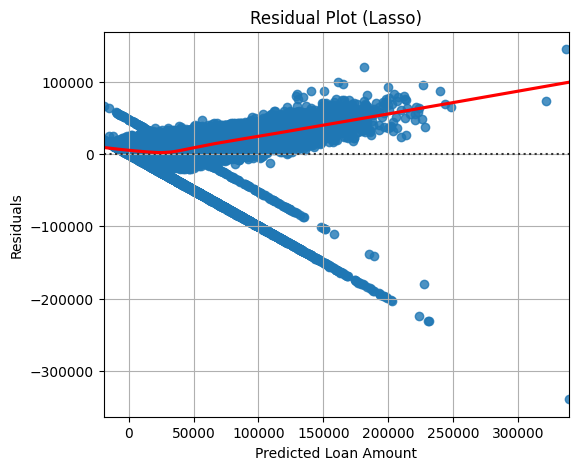

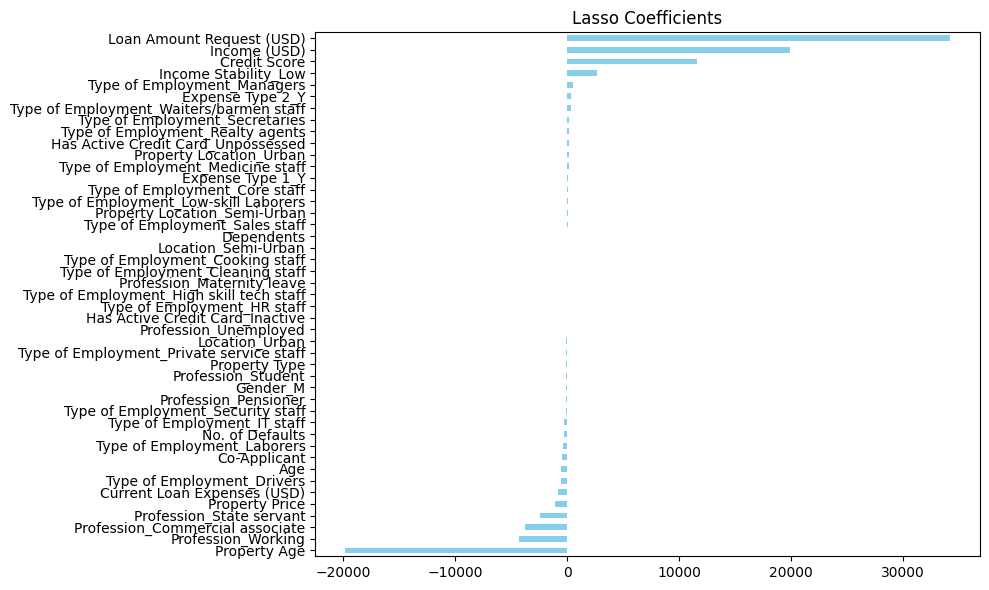


Ridge Performance:
MAE: 21754.1187
MSE: 983816352.2717
RMSE: 31351.3020
R²: 0.5722
Adjusted R²: 0.5690


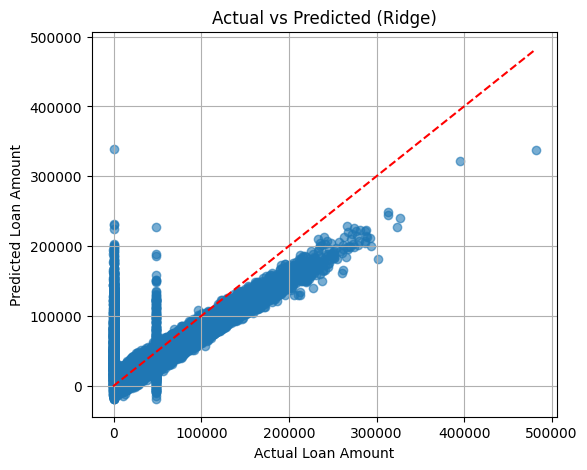

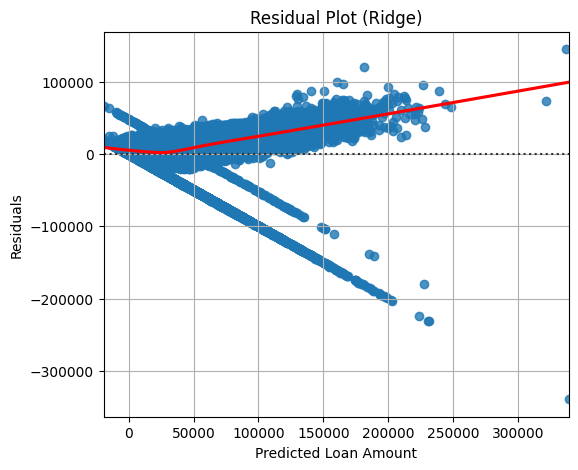

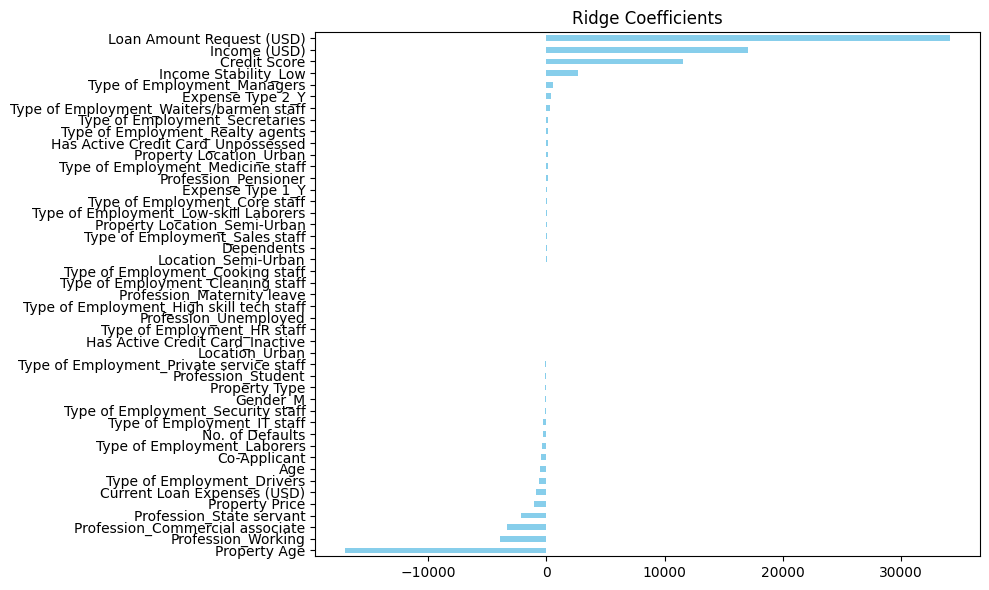


Elastic Net Performance:
MAE: 21775.0929
MSE: 981464886.9225
RMSE: 31314.1244
R²: 0.5732
Adjusted R²: 0.5700


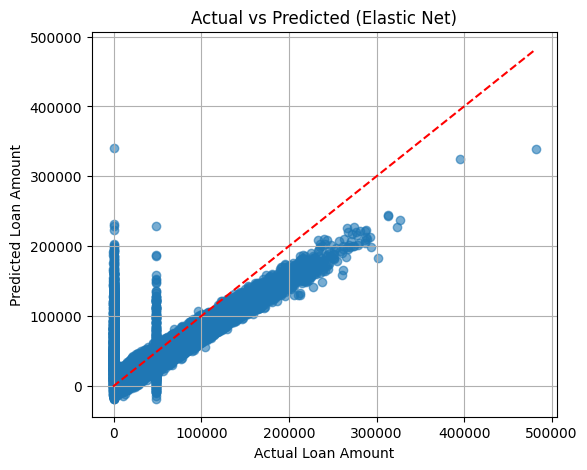

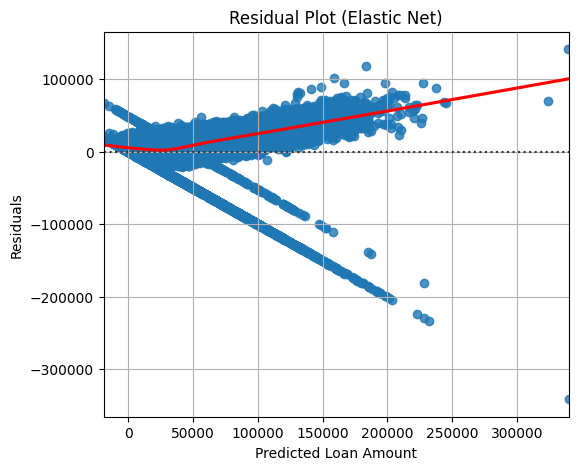

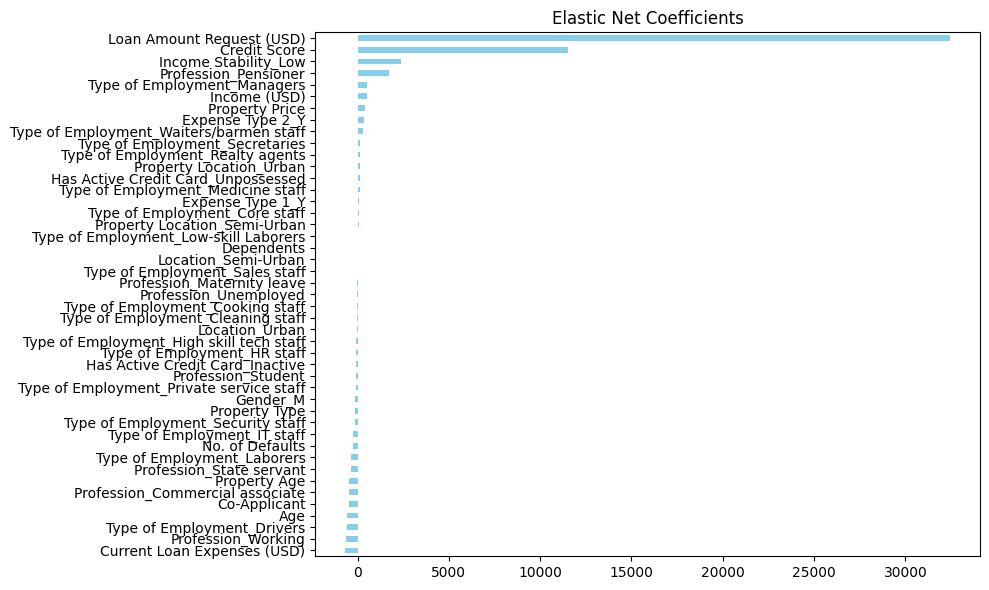


Table 1: Average 5-Fold Cross-Validation Results for All Models
| Model             |     MAE |         MSE |    RMSE |        R2 |    Adj_R2 |
|:------------------|--------:|------------:|--------:|----------:|----------:|
| SVR               | 34460.3 | 2.13456e+09 | 46199.9 | 0.0714704 | 0.0644526 |
| Decision Tree     | 14332.7 | 1.09266e+09 | 33036.4 | 0.524694  | 0.521102  |
| AdaBoost          | 26943.1 | 1.16048e+09 | 34059.6 | 0.495291  | 0.491476  |
| Gradient Boosting | 13638.4 | 5.75941e+08 | 23985.1 | 0.749594  | 0.747701  |
| XGBoost           | 12451.8 | 5.83299e+08 | 24145.6 | 0.746311  | 0.744394  |
| Lasso             | 21754.4 | 9.83913e+08 | 31352.8 | 0.572146  | 0.568913  |
| Ridge             | 21754.1 | 9.83816e+08 | 31351.3 | 0.572189  | 0.568955  |
| Elastic Net       | 21775.1 | 9.81465e+08 | 31314.1 | 0.57321   | 0.569984  |

Table 2: Final Test Set Results for All Models
| Model             |      MAE |         MSE |    RMSE |        R2 |    Adj_R2 |
|:----

In [8]:
# ------------------ Libraries ------------------
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ Scaling ------------------
X_scaled = StandardScaler().fit_transform(X)

# ------------------ Models ------------------
additional_models = {
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'Lasso': Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000)
}

# ------------------ Cross Validation ------------------
cv_results = []
final_test_results = []

for name, model in additional_models.items():
    fold_metrics = []

    # k-fold CV
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_values[train_idx], y_values[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)

        fold_metrics.append([mae, mse, rmse, r2, adj_r2])

    # Average CV results
    avg_metrics = np.mean(fold_metrics, axis=0)
    cv_results.append([name] + avg_metrics.tolist())

    # ---------------- Print per-model report ----------------
    print(f"\n{name} Performance:")
    print(f"MAE: {avg_metrics[0]:.4f}")
    print(f"MSE: {avg_metrics[1]:.4f}")
    print(f"RMSE: {avg_metrics[2]:.4f}")
    print(f"R²: {avg_metrics[3]:.4f}")
    print(f"Adjusted R²: {avg_metrics[4]:.4f}")

    # ---------------- Final Test on Full Holdout ----------------
    model.fit(X_scaled, y_values)
    y_pred_final = model.predict(X_scaled)

    mae = mean_absolute_error(y_values, y_pred_final)
    mse = mean_squared_error(y_values, y_pred_final)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_values, y_pred_final)
    adj_r2 = 1 - (1-r2)*(len(y_values)-1)/(len(y_values)-X_scaled.shape[1]-1)

    final_test_results.append([name, mae, mse, rmse, r2, adj_r2])

    # ---------------- Plots ----------------
    residuals = y_values - y_pred_final

    # 1. Actual vs Predicted
    plt.figure(figsize=(6,5))
    plt.scatter(y_values, y_pred_final, alpha=0.6)
    plt.xlabel("Actual Loan Amount")
    plt.ylabel("Predicted Loan Amount")
    plt.title(f"Actual vs Predicted ({name})")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.grid(True)
    plt.show()

    # 2. Residual Plot
    plt.figure(figsize=(6,5))
    sns.residplot(x=y_pred_final, y=residuals, lowess=True, line_kws={'color':'red'})
    plt.xlabel("Predicted Loan Amount")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot ({name})")
    plt.grid(True)
    plt.show()

    # 3. Feature Importance / Coefficients
    plt.figure(figsize=(10,6))
    if hasattr(model, 'coef_'):
        coef = pd.Series(model.coef_, index=X.columns)
        coef.sort_values().plot(kind='barh', color='skyblue')
        plt.title(f"{name} Coefficients")
    elif hasattr(model, 'feature_importances_'):
        fi = pd.Series(model.feature_importances_, index=X.columns)
        fi.sort_values().plot(kind='barh', color='lightgreen')
        plt.title(f"{name} Feature Importances")
    else:
        plt.text(0.5, 0.5, f"No coefficients/feature importance for {name}",
                 horizontalalignment='center', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ------------------ Final Tables ------------------
cv_df = pd.DataFrame(cv_results, columns=['Model','MAE','MSE','RMSE','R2','Adj_R2'])
test_df = pd.DataFrame(final_test_results, columns=['Model','MAE','MSE','RMSE','R2','Adj_R2'])

print("\nTable 1: Average 5-Fold Cross-Validation Results for All Models")
print(cv_df.to_markdown(index=False))

print("\nTable 2: Final Test Set Results for All Models")
print(test_df.to_markdown(index=False))
